In [5]:
# !pip install numpy
# !pip install matplotlib
# !pip install scipy
# !pip install pandas
# !pip install web3
# !pip install seaborn
#!pip install python-dotenv

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import json
import scipy as sp
import pandas as pd
from collections import defaultdict
from web3 import Web3
import seaborn as sns
from dotenv import dotenv_values

env_config = dotenv_values(".env") # .env file must contain the RPC_URL


In [2]:
w3 = Web3(Web3.HTTPProvider(env_config.RPC_URL))

In [3]:
w3.is_connected()

True

In [4]:
data = json.load(open("../tasks/gasExperiments/output_2023-06-28T19:45:14.127Z_mumbaiGasExp.json"))

In [5]:
_x = []
_y_run = []
_y_estimate = []
_df_dict = defaultdict(list)
c = 0
for d in data["experiment_runs"]:
    if "tx_distribute" in d:
        _x.append(int(d["n"]))
        _y_run.append(int(d["run_distribute"]))
        _y_estimate.append(int(d["estimate_distribute"]))
        _df_dict["n"].append(int(d["n"]))
        _df_dict["run_distribute"].append(int(d["run_distribute"]))
        _df_dict["estimate_distribute"].append(int(d["estimate_distribute"]))
        _df_dict["tx_hash"].append(d["tx_distribute"])
        txData = w3.eth.get_transaction(d["tx_distribute"])
        # print(txData.gasPrice, txData.gas, d["tx_distribute"])
        _df_dict["gas_price"].append(int(txData.gasPrice)/1000000000)
        _df_dict["tx_fee"].append(int(txData.gasPrice) * int(d["run_distribute"]))
        # break
    print("%d/%d" % (c, len(data["experiment_runs"])), end="\r")
    c += 1

df = pd.DataFrame(_df_dict)

3217412.7645872994 34813.65583823708


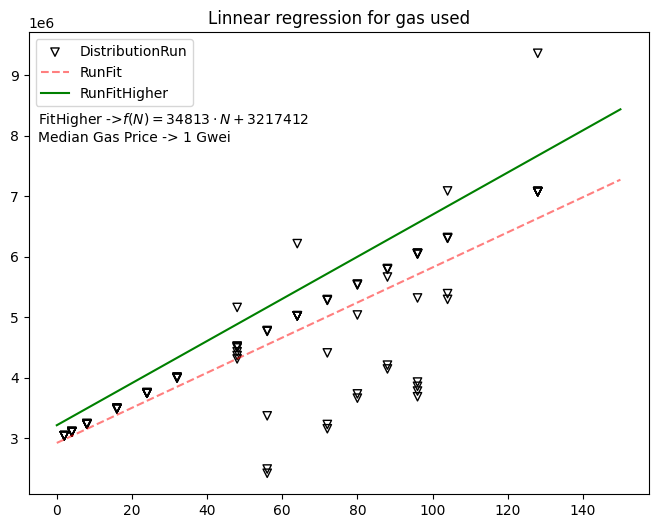

In [57]:
def plot_regression(x, y_estimate, y_run, ax, gas_price=None):
    res = sp.stats.linregress(x, y_estimate)
    xsample0 = np.linspace(0, 150, 100)
    ysample0 = res.intercept + res.slope*xsample0

    res = sp.stats.linregress(x, y_run)
    xsample = np.linspace(0, 150, 100)
    ysample = res.intercept + res.slope*xsample
    ysample2 = res.intercept*1.1 + res.slope*xsample*1.2

    print(res.intercept*1.1, res.slope*1.2)
    ax.scatter(x, y_run, marker="v",edgecolors="k",facecolors='none', label="DistributionRun")
    # plt.scatter(x, y_estimate, marker="^",edgecolors="b",facecolors='none', alpha=0.5, label="DistributionEstimate")
    ax.plot(xsample, ysample, "--r", alpha=0.5, label="RunFit")
    # plt.plot(xsample0, ysample0, "--g", alpha=0.5, label="EstimateFit")
    ax.plot(xsample0, ysample2, "g", label="RunFitHigher")
    ax.set_title("Linnear regression for gas used")
    ax.legend()
    ax.text(-5, 0.82e7, "FitHigher ->" + r"$f(N) = %d \cdot N + %d $" % (res.slope*1.2, res.intercept*1.1))
    if gas_price is not None:
        ax.text(-5, 0.79e7, "Median Gas Price -> %d Gwei" % gas_price)

fig = plt.figure(figsize=(8, 6))
ax0 = fig.add_subplot(111)
plot_regression(_x, _y_estimate, _y_run, ax0, gas_price=1)

3217412.7645872994 34813.65583823708


/tmp/ipykernel_1107/1312995796.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


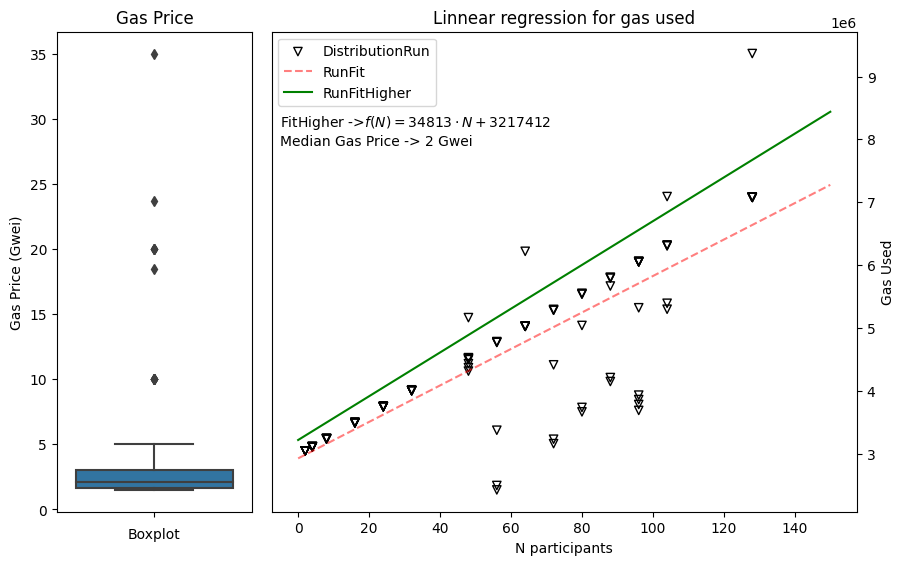

In [59]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(1, 2,  width_ratios=(1, 3),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

sns.boxplot(data=df, y="gas_price", ax=ax1)
ax1.set_ylabel("Gas Price (Gwei)")
ax1.set_xlabel("Boxplot")
ax1.set_title("Gas Price")

plot_regression(_x, _y_estimate, _y_run, ax2, gas_price=np.median(df["gas_price"]))
ax2.set_xlabel("N participants")
ax2.set_ylabel("Gas Used")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

plt.tight_layout()